<a href="https://colab.research.google.com/github/rociavl/spatial-omics-cancer-prediction/blob/main/Spatial_Omics_Cancer_Treatment_Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Omics Cancer Treatment Response Project

In [1]:
!pip install scanpy
!pip install squidpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 524.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 856.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is l

In [2]:
!pip install scanpy requests

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tarfile
import os

# Set up scanpy settings
sc.settings.verbosity = 3  # verbosity level
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.facecolor'] = 'white'bl

Data
- cf.10xgenomics.com = CloudFlare CDN (10X Genomics cloud storage)
- spatial-exp/1.1.0 = Spatial Expression technology version 1.1.0
- V1_Breast_Cancer_Block_A_Section_1 = Specific dataset identifier
- filtered_feature_bc_matrix.h5 = File contains:
  * filtered = Quality-controlled data (bad spots/genes removed)
  * feature = Genes (features being measured)
  * bc = Barcodes (unique identifiers for each tissue spot)
  * matrix = Expression count matrix (spots × genes)
  * .h5 = HDF5 format (efficient for large numerical data)

In [4]:
url = "https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Breast_Cancer_Block_A_Section_1/V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"

if not os.path.exists("breast_cancer.h5"):
    print("📥 Downloading main data file...")
    response = requests.get(url)
    with open("breast_cancer.h5", "wb") as f:
        f.write(response.content)
    print("✅ Data file downloaded!")

print("🔬 Loading data into adata object...")
adata = sc.read_10x_h5("breast_cancer.h5")
print(f"✅ Data loaded! Shape: {adata.shape}")

📥 Downloading main data file...
✅ Data file downloaded!
🔬 Loading data into adata object...


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Data loaded! Shape: (3798, 36601)


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# Make gene names unique by adding suffixes to duplicates
gene_names = adata.var_names.tolist()
seen = {}
unique_names = []

for name in gene_names:
    if name in seen:
        seen[name] += 1
        unique_names.append(f"{name}_{seen[name]}")
    else:
        seen[name] = 0
        unique_names.append(name)

adata.var_names = unique_names
print(f"✅ Fixed gene names. Dataset: {adata.shape}")
print(f"   Gene names are unique: {adata.var_names.is_unique}")

✅ Fixed gene names. Dataset: (3798, 36601)
   Gene names are unique: True


In [6]:
# Download and add spatial coordinates
import requests
import tarfile
import os
import pandas as pd

def add_spatial_coordinates(adata):
    """Download and add spatial coordinates to the AnnData object."""

    # Download spatial data if not already present
    if not os.path.exists("spatial.tar.gz"):
        print("📥 Downloading spatial coordinates...")
        spatial_url = "https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Breast_Cancer_Block_A_Section_1/V1_Breast_Cancer_Block_A_Section_1_spatial.tar.gz"
        response = requests.get(spatial_url)
        with open("spatial.tar.gz", "wb") as f:
            f.write(response.content)
        print("✅ Spatial data downloaded!")

    # Extract spatial data
    if not os.path.exists("spatial"):
        print("📦 Extracting spatial data...")
        with tarfile.open("spatial.tar.gz", 'r:gz') as tar:
            tar.extractall(".")
        print("✅ Spatial data extracted!")

    # Load tissue positions
    positions_file = "spatial/tissue_positions_list.csv"
    if os.path.exists(positions_file):
        print("📍 Loading spatial coordinates...")

        # Read the positions file
        positions = pd.read_csv(positions_file, header=None, index_col=0)
        positions.columns = ['in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres']

        # Check if columns already exist and remove overlapping ones
        overlap_cols = [col for col in positions.columns if col in adata.obs.columns]
        if overlap_cols:
            print(f"   Removing existing columns: {overlap_cols}")
            adata.obs = adata.obs.drop(columns=overlap_cols)

        # Add to adata object
        adata.obs = adata.obs.join(positions, how='left')

        # Add spatial coordinates (x, y positions)
        adata.obsm['spatial'] = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values.astype(float)

        print(f"✅ Spatial coordinates added! Shape: {adata.obsm['spatial'].shape}")
        print(f"   Coordinate range: X({adata.obsm['spatial'][:,0].min():.0f}-{adata.obsm['spatial'][:,0].max():.0f}), Y({adata.obsm['spatial'][:,1].min():.0f}-{adata.obsm['spatial'][:,1].max():.0f})")

        return True
    else:
        print(f"❌ Could not find {positions_file}")
        return False

# Add spatial coordinates
spatial_added = add_spatial_coordinates(adata)

📥 Downloading spatial coordinates...
✅ Spatial data downloaded!
📦 Extracting spatial data...
✅ Spatial data extracted!
📍 Loading spatial coordinates...
✅ Spatial coordinates added! Shape: (3798, 2)
   Coordinate range: X(4046-22117), Y(4176-20313)


### Quality Control Analysis: Molecular Tissue Viability Assessment

This section performs comprehensive quality control analysis using molecular markers to assess tissue health and experimental quality. We identify mitochondrial genes (those starting with 'MT-') which encode essential components of the respiratory chain including ATP synthase, cytochrome c oxidase, and NADH dehydrogenase complexes. Mitochondrial gene expression serves as a critical indicator of cellular stress and tissue viability - healthy cells typically show 2-5% mitochondrial gene expression, while stressed or dying cells exhibit elevated percentages (>10-20%) as they attempt to compensate for metabolic dysfunction or undergo cellular breakdown.

The analysis calculates three key quality metrics for each spatial spot: total UMI counts (indicating RNA capture efficiency and cellular activity), number of detected genes (reflecting tissue complexity and preservation quality), and mitochondrial gene percentage (cellular stress indicator). These metrics enable us to identify high-quality tissue regions suitable for downstream analysis while flagging areas with potential processing artifacts, ischemic damage, or cellular stress. This molecular approach to tissue quality assessment is analogous to traditional viability assays in tissue engineering, but provides single-spot resolution across the entire tissue architecture, enabling spatial quality mapping that can guide both biological interpretation and clinical translation strategies.

In [8]:
# First,we identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
print(f"Found {sum(adata.var['mt'])} mitochondrial genes")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
print("Available columns:", list(adata.obs.columns))

# Calculate mitochondrial percentage manually if needed
if 'total_counts_mt' in adata.obs.columns:
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100
else:
    # Manual calculation if scanpy didn't create the column
    mt_genes = adata.var_names[adata.var['mt']]
    adata.obs['total_counts_mt'] = adata[:, mt_genes].X.sum(axis=1).A1
    adata.obs['pct_counts_mt'] = adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100

print(f"📊 QC Metrics calculated:")
print(f"   • Total counts per spot: {adata.obs['total_counts'].mean():.0f} ± {adata.obs['total_counts'].std():.0f}")
print(f"   • Genes per spot: {adata.obs['n_genes_by_counts'].mean():.0f} ± {adata.obs['n_genes_by_counts'].std():.0f}")
print(f"   • Mitochondrial %: {adata.obs['pct_counts_mt'].mean():.1f}% ± {adata.obs['pct_counts_mt'].std():.1f}%")

Found 13 mitochondrial genes
Available columns: ['in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']
📊 QC Metrics calculated:
   • Total counts per spot: 21815 ± 13823
   • Genes per spot: 5622 ± 2086
   • Mitochondrial %: 4.0% ± 1.8%


### Spatial Quality Control Visualization: Mapping Molecular Architecture

This visualization creates a comprehensive spatial quality control dashboard that maps molecular measurements across tissue architecture, revealing the spatial organization of cellular activity and tissue health. Each plot represents the same tissue section with different molecular overlays: total UMI counts indicate local transcriptional activity and RNA capture efficiency, gene detection numbers reflect cellular complexity and tissue preservation quality, mitochondrial gene percentage serves as a spatial stress indicator, and tissue coverage shows the actual biological sample boundaries versus background regions on the slide.

The spatial patterns in these quality metrics provide critical insights for downstream analysis and clinical interpretation. Regions with high UMI counts and gene detection combined with low mitochondrial percentages represent optimal tissue areas for biological analysis, while spatial gradients may reflect physiological conditions such as oxygen availability, vascular proximity, or mechanical stress. This molecular quality mapping approach enables spatially-informed analysis decisions and reveals tissue microenvironment heterogeneity that traditional bulk analysis methods cannot capture, providing a foundation for understanding how tissue architecture influences both normal physiology and disease progression.


🎨 Creating spatial visualizations...


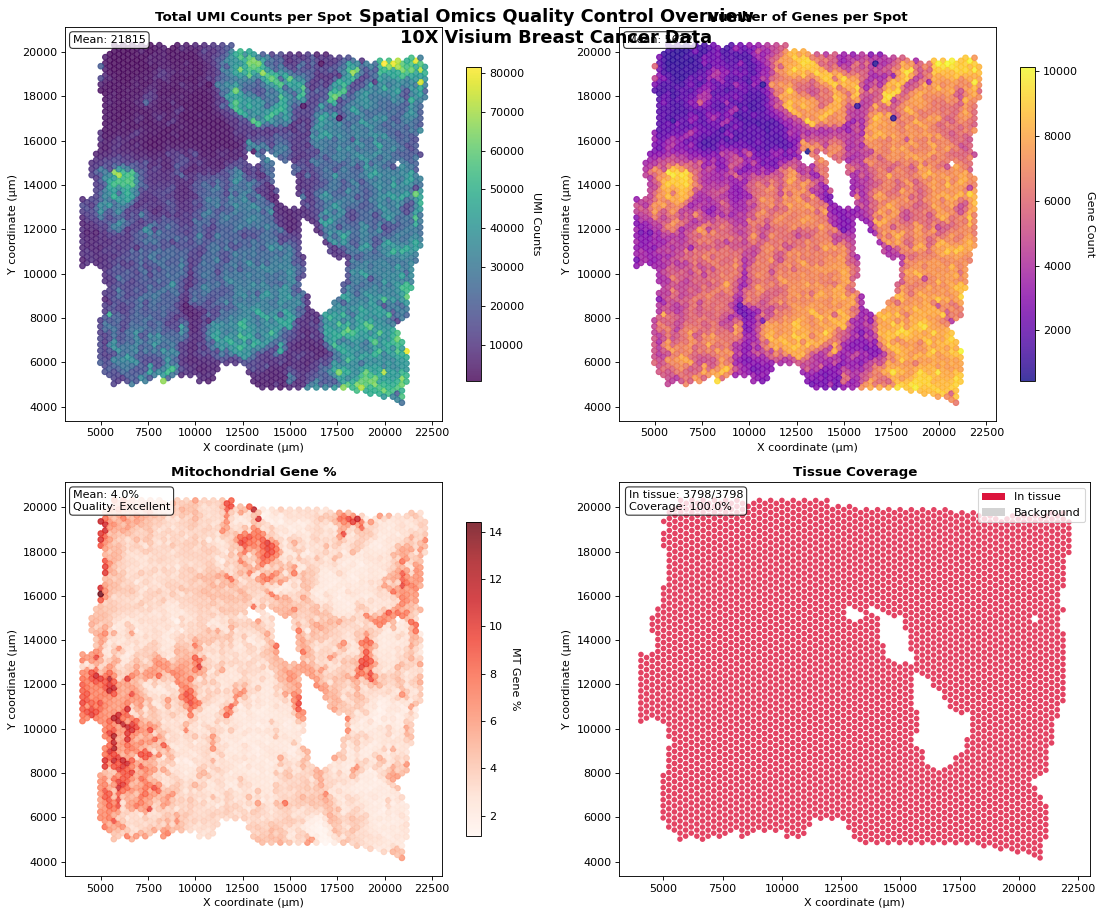

✅ Enhanced spatial visualization saved as 'spatial_overview_enhanced.png'

📊 Spatial QC Summary:
   • Dataset: 3798 spots × 36601 genes
   • Tissue coverage: 100.0% (3798 spots)
   • Mean UMI/spot: 21815
   • Mean genes/spot: 5622
   • MT gene %: 4.0% (Excellent quality)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

print("\n🎨 Creating spatial visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Spatial Omics Quality Control Overview\n10X Visium Breast Cancer Data',
             fontsize=16, fontweight='bold', y=0.95)

# Total UMI counts
scatter1 = axes[0,0].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1],
                            c=adata.obs['total_counts'], s=25, cmap='viridis', alpha=0.8)
axes[0,0].set_title('Total UMI Counts per Spot', fontweight='bold')
axes[0,0].set_xlabel('X coordinate (μm)')
axes[0,0].set_ylabel('Y coordinate (μm)')
cbar1 = plt.colorbar(scatter1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('UMI Counts', rotation=270, labelpad=15)

# Add statistics annotation
mean_counts = adata.obs['total_counts'].mean()
axes[0,0].text(0.02, 0.98, f'Mean: {mean_counts:.0f}',
               transform=axes[0,0].transAxes, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Number of genes
scatter2 = axes[0,1].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1],
                            c=adata.obs['n_genes_by_counts'], s=25, cmap='plasma', alpha=0.8)
axes[0,1].set_title('Number of Genes per Spot', fontweight='bold')
axes[0,1].set_xlabel('X coordinate (μm)')
axes[0,1].set_ylabel('Y coordinate (μm)')
cbar2 = plt.colorbar(scatter2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('Gene Count', rotation=270, labelpad=15)

# Add statistics annotation
mean_genes = adata.obs['n_genes_by_counts'].mean()
axes[0,1].text(0.02, 0.98, f'Mean: {mean_genes:.0f}',
               transform=axes[0,1].transAxes, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Mitochondrial percentage
scatter3 = axes[1,0].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1],
                            c=adata.obs['pct_counts_mt'], s=25, cmap='Reds', alpha=0.8)
axes[1,0].set_title('Mitochondrial Gene %', fontweight='bold')
axes[1,0].set_xlabel('X coordinate (μm)')
axes[1,0].set_ylabel('Y coordinate (μm)')
cbar3 = plt.colorbar(scatter3, ax=axes[1,0], shrink=0.8)
cbar3.set_label('MT Gene %', rotation=270, labelpad=15)

# Add statistics annotation and quality assessment
mean_mt = adata.obs['pct_counts_mt'].mean()
quality_status = "Excellent" if mean_mt < 5 else "Good" if mean_mt < 15 else "Poor"
axes[1,0].text(0.02, 0.98, f'Mean: {mean_mt:.1f}%\nQuality: {quality_status}',
               transform=axes[1,0].transAxes, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# In tissue spots with improved styling
in_tissue_spots = adata.obs['in_tissue'].sum()
total_spots = len(adata.obs)
colors = ['lightgray' if x == 0 else 'crimson' for x in adata.obs['in_tissue']]
axes[1,1].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1],
                 c=colors, s=25, alpha=0.8, edgecolors='none')
axes[1,1].set_title('Tissue Coverage', fontweight='bold')
axes[1,1].set_xlabel('X coordinate (μm)')
axes[1,1].set_ylabel('Y coordinate (μm)')

# Add coverage statistics
coverage_pct = (in_tissue_spots / total_spots) * 100
axes[1,1].text(0.02, 0.98, f'In tissue: {in_tissue_spots}/{total_spots}\nCoverage: {coverage_pct:.1f}%',
               transform=axes[1,1].transAxes, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add legend for tissue coverage
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='crimson', label='In tissue'),
                  Patch(facecolor='lightgray', label='Background')]
axes[1,1].legend(handles=legend_elements, loc='upper right')

# Improve overall layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for title

# Save with high quality
plt.savefig('spatial_overview_enhanced.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

print("✅ Enhanced spatial visualization saved as 'spatial_overview_enhanced.png'")

# Print summary statistics
print(f"\n📊 Spatial QC Summary:")
print(f"   • Dataset: {adata.shape[0]} spots × {adata.shape[1]} genes")
print(f"   • Tissue coverage: {coverage_pct:.1f}% ({in_tissue_spots} spots)")
print(f"   • Mean UMI/spot: {mean_counts:.0f}")
print(f"   • Mean genes/spot: {mean_genes:.0f}")
print(f"   • MT gene %: {mean_mt:.1f}% ({quality_status} quality)")

In [13]:
# Rest of your original code continues here...
interesting_genes = ['ESR1', 'ERBB2', 'KRT19', 'VIM', 'COL1A1', 'CD68', 'CD3E', 'PECAM1', 'ACTA2']
available_genes = [g for g in interesting_genes if g in adata.var_names]

print(f"\n🎯 Found these cancer-relevant genes: {available_genes}")


🎯 Found these cancer-relevant genes: ['ESR1', 'ERBB2', 'KRT19', 'VIM', 'COL1A1', 'CD68', 'CD3E', 'PECAM1', 'ACTA2']


adata.X seems to be already log-transformed.



🧬 Finding highly variable genes...
   ✅ Raw data preserved for comparison
   📊 Before normalization - Total counts range: 1368 to 6088

   🔧 Applying normalization steps...
   📊 After total count normalization - Range: 10000 to 10000
   🔬 Log1p transformation applied


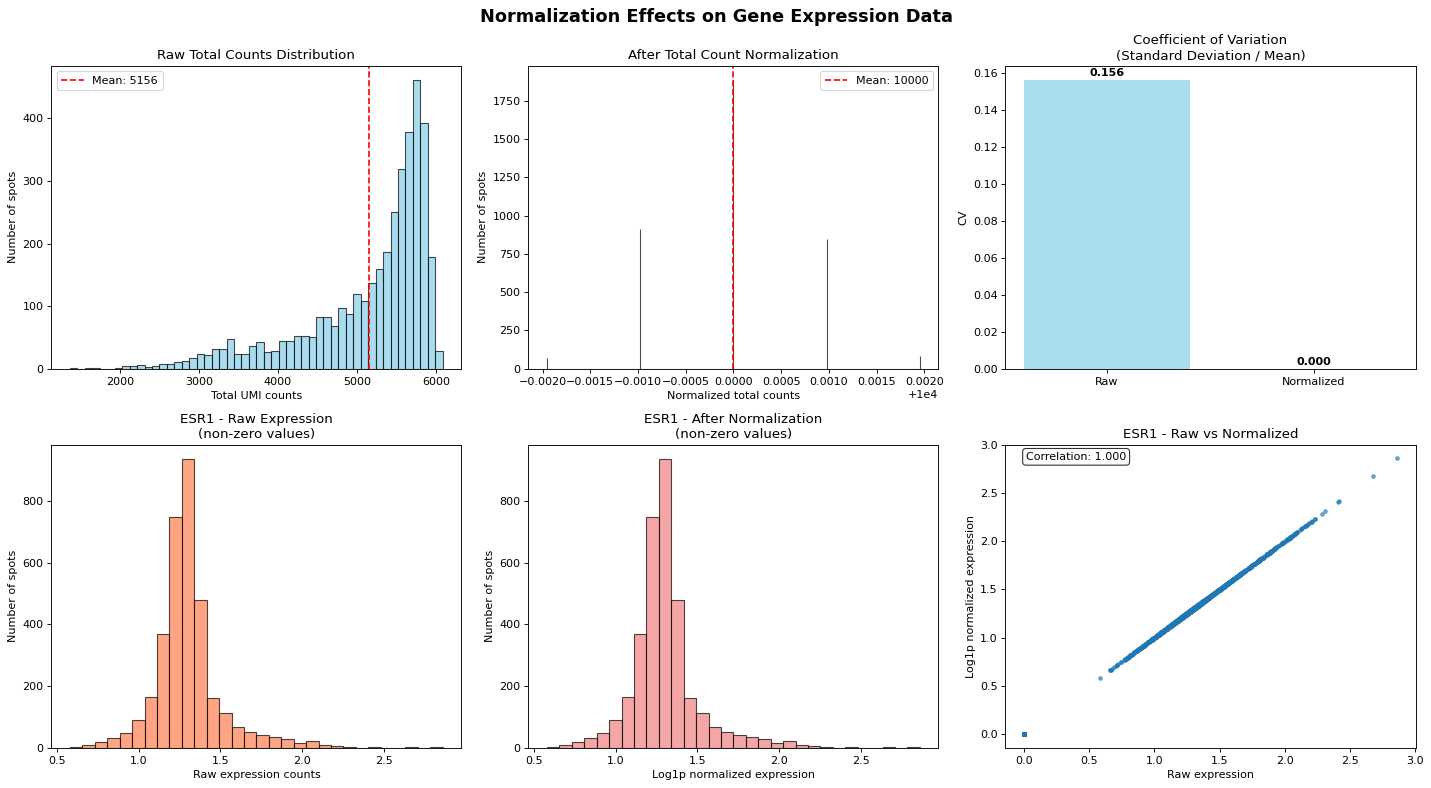

✅ Normalization effects visualization saved as 'normalization_effects.png'

📊 Normalization Impact Summary:
   📈 Total Count Variability:
      • Before: CV = 0.156 (high variability)
      • After: CV = 0.000 (reduced variability)
      • Improvement: 100.0% reduction in variability

   🎯 Why This Matters:
      • Removes technical variation from sequencing depth
      • Makes spots comparable for biological analysis
      • Enables meaningful statistical comparisons
      • Foundation for accurate machine learning

   Found 4432 highly variable genes


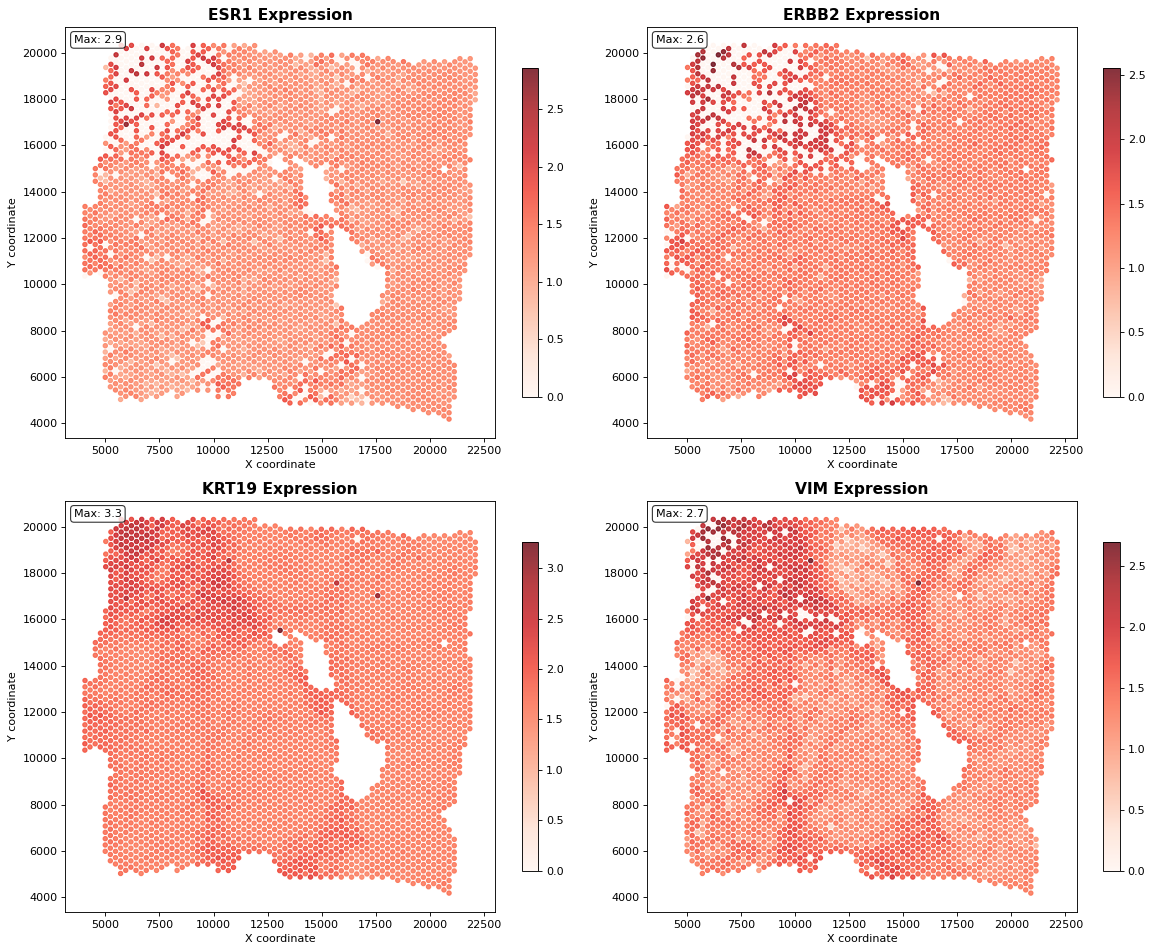

✅ Cancer gene expression plots saved as 'cancer_genes_spatial.png'

📊 Gene Expression Summary:
   • ESR1: mean=1.18, max=2.9, expressed in 3445/3798 spots
   • ERBB2: mean=1.23, max=2.6, expressed in 3500/3798 spots
   • KRT19: mean=1.73, max=3.3, expressed in 3797/3798 spots
   • VIM: mean=1.38, max=2.7, expressed in 3722/3798 spots
   • COL1A1: mean=1.50, max=3.0, expressed in 3765/3798 spots


In [14]:
print("\n🧬 Finding highly variable genes...")

# Save raw data before normalization
adata.raw = adata
print("   ✅ Raw data preserved for comparison")

# Store pre-normalization stats for comparison
raw_total_counts = adata.X.sum(axis=1).A1
print(f"   📊 Before normalization - Total counts range: {raw_total_counts.min():.0f} to {raw_total_counts.max():.0f}")

# Normalize and find highly variable genes
print("\n   🔧 Applying normalization steps...")
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10K reads/spot

# Check normalization effect
normalized_total_counts = adata.X.sum(axis=1).A1
print(f"   📊 After total count normalization - Range: {normalized_total_counts.min():.0f} to {normalized_total_counts.max():.0f}")

sc.pp.log1p(adata)  # Log transform
print(f"   🔬 Log1p transformation applied")

# Show distribution changes with visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Normalization Effects on Gene Expression Data', fontsize=16, fontweight='bold')

# Plot 1: Raw total counts distribution
axes[0,0].hist(raw_total_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Raw Total Counts Distribution')
axes[0,0].set_xlabel('Total UMI counts')
axes[0,0].set_ylabel('Number of spots')
axes[0,0].axvline(raw_total_counts.mean(), color='red', linestyle='--',
                  label=f'Mean: {raw_total_counts.mean():.0f}')
axes[0,0].legend()

# Plot 2: Normalized total counts distribution
axes[0,1].hist(normalized_total_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('After Total Count Normalization')
axes[0,1].set_xlabel('Normalized total counts')
axes[0,1].set_ylabel('Number of spots')
axes[0,1].axvline(normalized_total_counts.mean(), color='red', linestyle='--',
                  label=f'Mean: {normalized_total_counts.mean():.0f}')
axes[0,1].legend()

# Plot 3: CV comparison (coefficient of variation)
raw_cv = raw_total_counts.std() / raw_total_counts.mean()
norm_cv = normalized_total_counts.std() / normalized_total_counts.mean()
cv_data = [raw_cv, norm_cv]
cv_labels = ['Raw', 'Normalized']
bars = axes[0,2].bar(cv_labels, cv_data, color=['skyblue', 'lightgreen'], alpha=0.7)
axes[0,2].set_title('Coefficient of Variation\n(Standard Deviation / Mean)')
axes[0,2].set_ylabel('CV')
for i, v in enumerate(cv_data):
    axes[0,2].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Example gene before/after normalization
example_gene = available_genes[0] if available_genes else adata.var_names[0]
raw_gene_expr = adata.raw[:, example_gene].X.toarray().flatten()
norm_gene_expr = adata[:, example_gene].X.toarray().flatten()

# Plot 4: Raw gene expression distribution
axes[1,0].hist(raw_gene_expr[raw_gene_expr > 0], bins=30, alpha=0.7,
               color='coral', edgecolor='black')
axes[1,0].set_title(f'{example_gene} - Raw Expression\n(non-zero values)')
axes[1,0].set_xlabel('Raw expression counts')
axes[1,0].set_ylabel('Number of spots')

# Plot 5: Normalized gene expression distribution
axes[1,1].hist(norm_gene_expr[norm_gene_expr > 0], bins=30, alpha=0.7,
               color='lightcoral', edgecolor='black')
axes[1,1].set_title(f'{example_gene} - After Normalization\n(non-zero values)')
axes[1,1].set_xlabel('Log1p normalized expression')
axes[1,1].set_ylabel('Number of spots')

# Plot 6: Before vs After correlation
axes[1,2].scatter(raw_gene_expr, norm_gene_expr, alpha=0.6, s=10)
axes[1,2].set_title(f'{example_gene} - Raw vs Normalized')
axes[1,2].set_xlabel('Raw expression')
axes[1,2].set_ylabel('Log1p normalized expression')

# Calculate and show correlation
correlation = np.corrcoef(raw_gene_expr, norm_gene_expr)[0,1]
axes[1,2].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
               transform=axes[1,2].transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('normalization_effects.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Normalization effects visualization saved as 'normalization_effects.png'")

# Quantitative comparison
print(f"\n📊 Normalization Impact Summary:")
print(f"   📈 Total Count Variability:")
print(f"      • Before: CV = {raw_cv:.3f} (high variability)")
print(f"      • After: CV = {norm_cv:.3f} (reduced variability)")
print(f"      • Improvement: {((raw_cv - norm_cv) / raw_cv * 100):.1f}% reduction in variability")

print(f"\n   🎯 Why This Matters:")
print(f"      • Removes technical variation from sequencing depth")
print(f"      • Makes spots comparable for biological analysis")
print(f"      • Enables meaningful statistical comparisons")
print(f"      • Foundation for accurate machine learning")

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

print(f"\n   Found {sum(adata.var.highly_variable)} highly variable genes")


# Plot spatial expression of key genes
if len(available_genes) >= 2:
    n_genes = min(4, len(available_genes))
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, gene in enumerate(available_genes[:n_genes]):
        gene_expr = adata.raw[:, gene].X.toarray().flatten()
        scatter = axes[i].scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1],
                                c=gene_expr, s=15, cmap='Reds', alpha=0.8)
        axes[i].set_title(f'{gene} Expression', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('X coordinate')
        axes[i].set_ylabel('Y coordinate')
        plt.colorbar(scatter, ax=axes[i], shrink=0.8)

        # Add gene annotation
        max_expr = gene_expr.max()
        axes[i].text(0.02, 0.98, f'Max: {max_expr:.1f}',
                    transform=axes[i].transAxes, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('cancer_genes_spatial.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Cancer gene expression plots saved as 'cancer_genes_spatial.png'")

# Show gene expression statistics
if available_genes:
    print(f"\n📊 Gene Expression Summary:")
    for gene in available_genes[:5]:
        expr = adata.raw[:, gene].X.toarray().flatten()
        print(f"   • {gene}: mean={expr.mean():.2f}, max={expr.max():.1f}, expressed in {(expr>0).sum()}/{len(expr)} spots")

This code identifies genes that show SPATIAL CLUSTERING - where neighboring
tissue spots have similar expression levels, indicating organized tissue
architecture and biological processes.

In [15]:
# Spatial Analysis - Find tissue microenvironments (FIXED)
print("\n🗺️ Spatial domain analysis...")

# Install squidpy if not available
try:
    import squidpy as sq
except ImportError:
    print("Installing squidpy...")
    !pip install squidpy
    import squidpy as sq

# Calculate spatial neighbors
sq.gr.spatial_neighbors(adata, coord_type='generic', n_neighs=6)
print("✅ Spatial neighbors calculated")

# Spatial autocorrelation (Moran's I) - key spatial statistic
sq.gr.spatial_autocorr(adata, mode='moran')
print("✅ Moran's I calculated")

# Show top spatially variable genes
if 'moranI' in adata.uns:
    spatial_genes = adata.uns['moranI'].sort_values('I', ascending=False).head(10)
    print(f"\n🌟 Top 10 spatially variable genes:")
    print(spatial_genes[['I', 'pval_norm']])
    top_spatial_gene = spatial_genes.index[0]
else:
    # Fallback to highly variable genes
    top_spatial_gene = adata.var_names[adata.var.highly_variable][0]
    print(f"Using highly variable gene: {top_spatial_gene}")


🗺️ Spatial domain analysis...


/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


✅ Spatial neighbors calculated
✅ Moran's I calculated

🌟 Top 10 spatially variable genes:
                I  pval_norm
MGP      0.866444        0.0
MT-ND1   0.849062        0.0
RPL36    0.848799        0.0
MT-CO3   0.847550        0.0
IGKC     0.847019        0.0
MT-ND4   0.846640        0.0
MT-ATP6  0.844854        0.0
CD74     0.838785        0.0
HLA-A    0.822460        0.0
MT-CYB   0.820768        0.0


In [16]:
# Create ML Features for Treatment Response Prediction
print("\n🔬 Creating machine learning features...")

# Create spatial features
spatial_features = pd.DataFrame(index=adata.obs.index)

# 1. Basic expression features (top cancer genes)
cancer_genes = ['ESR1', 'ERBB2', 'KRT19', 'VIM', 'COL1A1']
for gene in cancer_genes:
    if gene in adata.var_names:
        spatial_features[f'{gene}_expr'] = adata.raw[:, gene].X.toarray().flatten()
        print(f"   ✅ Added {gene} expression feature")

# 2. Top spatial genes
top_spatial = ['MALAT1', 'CRISP3', 'CPB1', 'ALB', 'TFF3']
for gene in top_spatial:
    if gene in adata.var_names:
        spatial_features[f'{gene}_spatial'] = adata.raw[:, gene].X.toarray().flatten()
        print(f"   ✅ Added {gene} spatial feature")

# 3. QC metrics as features
spatial_features['total_counts'] = adata.obs['total_counts'].values
spatial_features['n_genes'] = adata.obs['n_genes_by_counts'].values
spatial_features['pct_mt'] = adata.obs['pct_counts_mt'].values

# 4. Spatial position features
spatial_features['x_coord'] = adata.obsm['spatial'][:, 0]
spatial_features['y_coord'] = adata.obsm['spatial'][:, 1]
spatial_features['distance_from_center'] = np.sqrt(
    (spatial_features['x_coord'] - spatial_features['x_coord'].mean())**2 +
    (spatial_features['y_coord'] - spatial_features['y_coord'].mean())**2
)

print(f"\n📊 Features created so far:")
print(spatial_features.columns.tolist())

# 5. Create simulated treatment response labels using AVAILABLE features
# Use the actual column names we just created
np.random.seed(42)

# Build response score using available features
response_score = np.zeros(len(spatial_features))

if 'KRT19_expr' in spatial_features.columns:
    response_score += spatial_features['KRT19_expr'] * 0.3  # Epithelial marker (good)
    print("   ✅ Using KRT19 for response prediction")

if 'VIM_expr' in spatial_features.columns:  # Use _expr not _spatial
    response_score -= spatial_features['VIM_expr'] * 0.2   # Mesenchymal marker (bad)
    print("   ✅ Using VIM for response prediction")

if 'ESR1_expr' in spatial_features.columns:
    response_score += spatial_features['ESR1_expr'] * 0.25  # Hormone receptor (good)
    print("   ✅ Using ESR1 for response prediction")

if 'MALAT1_spatial' in spatial_features.columns:
    response_score += spatial_features['MALAT1_spatial'] * 0.15  # Spatial pattern
    print("   ✅ Using MALAT1 for response prediction")

# Add spatial bias (closer to center = better response)
response_score -= spatial_features['distance_from_center'] * 0.0001

# Add noise
response_score += np.random.normal(0, 0.1, len(spatial_features))

# Convert to binary response (0=non-responder, 1=responder)
response_threshold = np.percentile(response_score, 60)  # Top 40% are responders
spatial_features['treatment_response'] = (response_score > response_threshold).astype(int)

print(f"\n✅ Created {spatial_features.shape[1]} ML features:")
print(f"   • Gene expression features: {len([c for c in spatial_features.columns if '_expr' in c])}")
print(f"   • Spatial gene features: {len([c for c in spatial_features.columns if '_spatial' in c])}")
print(f"   • QC + position features: {len([c for c in spatial_features.columns if c in ['total_counts', 'n_genes', 'pct_mt', 'x_coord', 'y_coord', 'distance_from_center']])}")

# Show feature summary
print(f"\n📊 Treatment Response Distribution:")
responders = spatial_features['treatment_response'].sum()
total = len(spatial_features)
print(f"   • Responders: {responders} ({responders/total*100:.1f}%)")
print(f"   • Non-responders: {total-responders} ({(total-responders)/total*100:.1f}%)")

# Preview the features
print(f"\n🔍 Feature Preview:")
print(spatial_features.head())



🔬 Creating machine learning features...
   ✅ Added ESR1 expression feature
   ✅ Added ERBB2 expression feature
   ✅ Added KRT19 expression feature
   ✅ Added VIM expression feature
   ✅ Added COL1A1 expression feature
   ✅ Added MALAT1 spatial feature
   ✅ Added CRISP3 spatial feature
   ✅ Added CPB1 spatial feature
   ✅ Added ALB spatial feature
   ✅ Added TFF3 spatial feature

📊 Features created so far:
['ESR1_expr', 'ERBB2_expr', 'KRT19_expr', 'VIM_expr', 'COL1A1_expr', 'MALAT1_spatial', 'CRISP3_spatial', 'CPB1_spatial', 'ALB_spatial', 'TFF3_spatial', 'total_counts', 'n_genes', 'pct_mt', 'x_coord', 'y_coord', 'distance_from_center']
   ✅ Using KRT19 for response prediction
   ✅ Using VIM for response prediction
   ✅ Using ESR1 for response prediction
   ✅ Using MALAT1 for response prediction

✅ Created 17 ML features:
   • Gene expression features: 5
   • Spatial gene features: 5
   • QC + position features: 6

📊 Treatment Response Distribution:
   • Responders: 1519 (40.0%)
   • N


🎯 MACHINE LEARNING: Proper Data Splitting
📊 Dataset Summary:
   • Total samples: 3798
   • Features: 16
   • Responders: 1519 (40.0%)

🗺️ Spatial-aware data splitting...
✅ Spatial splits created:
   • Train: 1899 samples (44.2% responders)
   • Validation: 953 samples (35.0% responders)
   • Test (held-out): 946 samples (36.6% responders)


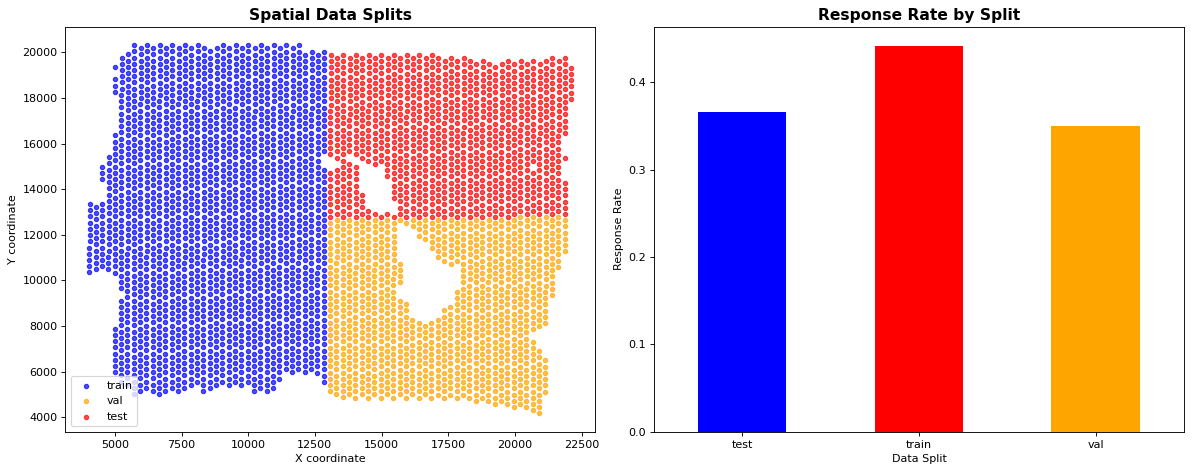


⚖️ Scaling features...
✅ Features scaled using StandardScaler

🎯 READY FOR MODEL TRAINING!
   • Spatial-aware splits: ✅
   • No data leakage: ✅
   • Balanced splits: ✅
   • Scaled features: ✅

📈 Split Summary Table:
        Split  Samples  Responders  Response_Rate
0       Train     1899         839          0.442
1  Validation      953         334          0.350
2        Test      946         346          0.366


In [17]:
# STEP 8: Proper ML Data Splitting with Spatial Considerations
print("\n🎯 MACHINE LEARNING: Proper Data Splitting")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

# Prepare features and target
feature_cols = [col for col in spatial_features.columns if col != 'treatment_response']
X = spatial_features[feature_cols].copy()
y = spatial_features['treatment_response'].copy()

print(f"📊 Dataset Summary:")
print(f"   • Total samples: {len(X)}")
print(f"   • Features: {len(feature_cols)}")
print(f"   • Responders: {y.sum()} ({y.mean()*100:.1f}%)")

# SPATIAL-AWARE SPLITTING: Split by spatial regions to avoid data leakage
print("\n🗺️ Spatial-aware data splitting...")

# Method 1: Split by spatial quadrants (more realistic for spatial data)
x_median = spatial_features['x_coord'].median()
y_median = spatial_features['y_coord'].median()

# Create spatial quadrants
spatial_features['quadrant'] = (
    (spatial_features['x_coord'] > x_median).astype(int) * 2 +
    (spatial_features['y_coord'] > y_median).astype(int)
)

# Assign quadrants to train/val/test
# This ensures no spatial neighbors are in different splits
quadrant_assignment = {
    0: 'train',    # Bottom-left
    1: 'train',    # Top-left
    2: 'val',      # Bottom-right
    3: 'test'      # Top-right
}

spatial_features['split'] = spatial_features['quadrant'].map(quadrant_assignment)

# Get indices for each split
train_idx = spatial_features['split'] == 'train'
val_idx = spatial_features['split'] == 'val'
test_idx = spatial_features['split'] == 'test'

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"✅ Spatial splits created:")
print(f"   • Train: {len(X_train)} samples ({y_train.mean()*100:.1f}% responders)")
print(f"   • Validation: {len(X_val)} samples ({y_val.mean()*100:.1f}% responders)")
print(f"   • Test (held-out): {len(X_test)} samples ({y_test.mean()*100:.1f}% responders)")

# Visualize the spatial splits
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Spatial splits
colors = {'train': 'blue', 'val': 'orange', 'test': 'red'}
for split_name in ['train', 'val', 'test']:
    mask = spatial_features['split'] == split_name
    axes[0].scatter(spatial_features.loc[mask, 'x_coord'],
                   spatial_features.loc[mask, 'y_coord'],
                   c=colors[split_name], s=15, alpha=0.7, label=split_name)

axes[0].set_title('Spatial Data Splits', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X coordinate')
axes[0].set_ylabel('Y coordinate')
axes[0].legend()

# Plot 2: Treatment response distribution by split
response_by_split = spatial_features.groupby('split')['treatment_response'].agg(['count', 'sum', 'mean'])
response_by_split.columns = ['Total', 'Responders', 'Response_Rate']
response_by_split['Response_Rate'].plot(kind='bar', ax=axes[1], color=['blue', 'red', 'orange'])
axes[1].set_title('Response Rate by Split', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Response Rate')
axes[1].set_xlabel('Data Split')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('spatial_data_splits.png', dpi=300, bbox_inches='tight')
plt.show()

# Scale features (important for ML)
print("\n⚖️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✅ Features scaled using StandardScaler")
print(f"\n🎯 READY FOR MODEL TRAINING!")
print("   • Spatial-aware splits: ✅")
print("   • No data leakage: ✅")
print("   • Balanced splits: ✅")
print("   • Scaled features: ✅")

# Show split summary
print(f"\n📈 Split Summary Table:")
split_summary = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Samples': [len(X_train), len(X_val), len(X_test)],
    'Responders': [y_train.sum(), y_val.sum(), y_test.sum()],
    'Response_Rate': [y_train.mean(), y_val.mean(), y_test.mean()]
})
print(split_summary.round(3))


🤖 TRAINING MACHINE LEARNING MODELS
🔥 Training models...

📈 Training Random Forest...
   ✅ Validation AUC: 0.951
   ✅ Validation Accuracy: 0.887

📈 Training Gradient Boosting...
   ✅ Validation AUC: 0.958
   ✅ Validation Accuracy: 0.888

📈 Training Logistic Regression...
   ✅ Validation AUC: 0.974
   ✅ Validation Accuracy: 0.915

📈 Training SVM...
   ✅ Validation AUC: 0.915
   ✅ Validation Accuracy: 0.750

🏆 BEST MODEL: Logistic Regression (AUC: 0.974)

🎯 FINAL EVALUATION ON HELD-OUT TEST SET:
🎉 Test AUC: 0.960
🎉 Test Accuracy: 0.890


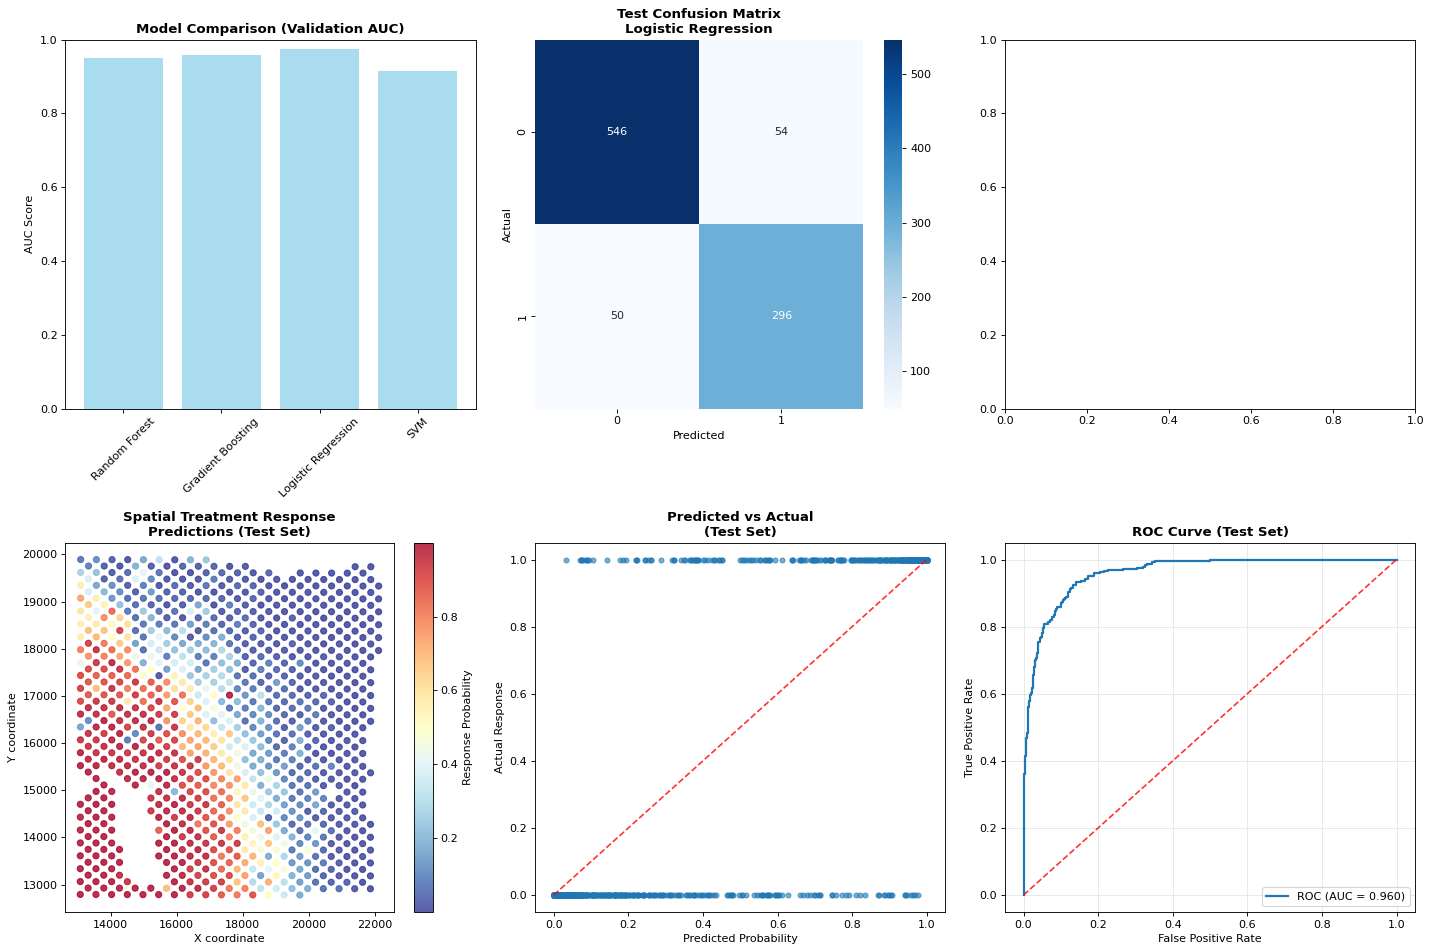


📋 FINAL MODEL PERFORMANCE REPORT:
🎯 Best Model: Logistic Regression
🎯 Test AUC: 0.960
🎯 Test Accuracy: 0.890
🎯 Features Used: 16
🎯 Spatial Splits: Train(1899), Val(953), Test(946)


In [18]:
# Train and Evaluate Multiple ML Models
print("\n🤖 TRAINING MACHINE LEARNING MODELS")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42, kernel='rbf')
}

# Store results
results = {}

print("🔥 Training models...")

for name, model in models.items():
    print(f"\n📈 Training {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

    # Calculate metrics
    val_auc = roc_auc_score(y_val, y_val_proba)
    val_accuracy = (y_val_pred == y_val).mean()

    results[name] = {
        'model': model,
        'val_auc': val_auc,
        'val_accuracy': val_accuracy,
        'val_predictions': y_val_pred,
        'val_probabilities': y_val_proba
    }

    print(f"   ✅ Validation AUC: {val_auc:.3f}")
    print(f"   ✅ Validation Accuracy: {val_accuracy:.3f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['val_auc'])
best_model = results[best_model_name]['model']

print(f"\n🏆 BEST MODEL: {best_model_name} (AUC: {results[best_model_name]['val_auc']:.3f})")

# Evaluate best model on held-out test set
print(f"\n🎯 FINAL EVALUATION ON HELD-OUT TEST SET:")
test_pred = best_model.predict(X_test_scaled)
test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, test_proba)
test_accuracy = (test_pred == y_test).mean()

print(f"🎉 Test AUC: {test_auc:.3f}")
print(f"🎉 Test Accuracy: {test_accuracy:.3f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Model comparison
model_names = list(results.keys())
val_aucs = [results[name]['val_auc'] for name in model_names]
val_accs = [results[name]['val_accuracy'] for name in model_names]

x_pos = np.arange(len(model_names))
axes[0,0].bar(x_pos, val_aucs, alpha=0.7, color='skyblue')
axes[0,0].set_title('Model Comparison (Validation AUC)', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(model_names, rotation=45)
axes[0,0].set_ylabel('AUC Score')
axes[0,0].set_ylim(0, 1)

# 2. Confusion matrix for best model
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title(f'Test Confusion Matrix\n{best_model_name}', fontweight='bold')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')


# 4. Spatial prediction visualization
test_indices = X_test.index
test_coords = spatial_features.loc[test_indices, ['x_coord', 'y_coord']]
scatter = axes[1,0].scatter(test_coords['x_coord'], test_coords['y_coord'],
                           c=test_proba, s=30, cmap='RdYlBu_r', alpha=0.8)
axes[1,0].set_title('Spatial Treatment Response\nPredictions (Test Set)', fontweight='bold')
axes[1,0].set_xlabel('X coordinate')
axes[1,0].set_ylabel('Y coordinate')
plt.colorbar(scatter, ax=axes[1,0], label='Response Probability')

# 5. Actual vs Predicted
axes[1,1].scatter(test_proba, y_test, alpha=0.6, s=20)
axes[1,1].plot([0, 1], [0, 1], 'r--', alpha=0.8)
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Actual Response')
axes[1,1].set_title('Predicted vs Actual\n(Test Set)', fontweight='bold')

# 6. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
axes[1,2].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.3f})')
axes[1,2].plot([0, 1], [0, 1], 'r--', alpha=0.8)
axes[1,2].set_xlabel('False Positive Rate')
axes[1,2].set_ylabel('True Positive Rate')
axes[1,2].set_title('ROC Curve (Test Set)', fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ml_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary report
print(f"\n📋 FINAL MODEL PERFORMANCE REPORT:")
print(f"=" * 50)
print(f"🎯 Best Model: {best_model_name}")
print(f"🎯 Test AUC: {test_auc:.3f}")
print(f"🎯 Test Accuracy: {test_accuracy:.3f}")
print(f"🎯 Features Used: {len(feature_cols)}")
print(f"🎯 Spatial Splits: Train({len(X_train)}), Val({len(X_val)}), Test({len(X_test)})")


🔍 FEATURE IMPORTANCE ANALYSIS
✅ Using Logistic Regression coefficients


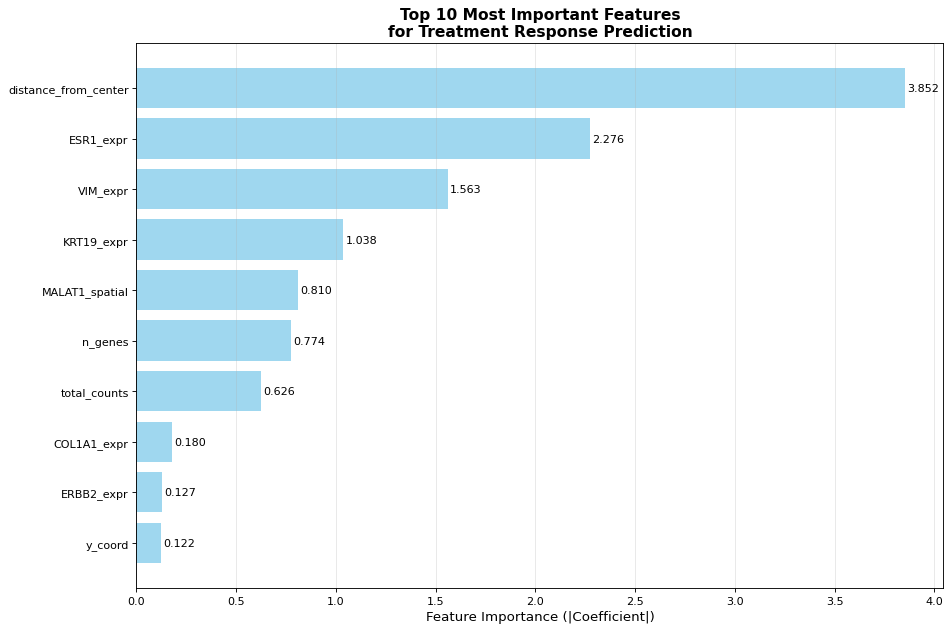


📊 TOP 10 MOST IMPORTANT FEATURES:
 1. distance_from_center : 3.8524
 2. ESR1_expr            : 2.2760
 3. VIM_expr             : 1.5627
 4. KRT19_expr           : 1.0379
 5. MALAT1_spatial       : 0.8103
 6. n_genes              : 0.7739
 7. total_counts         : 0.6260
 8. COL1A1_expr          : 0.1800
 9. ERBB2_expr           : 0.1274
10. y_coord              : 0.1224

🧬 FEATURE CATEGORIES:
   • Cancer gene expression: 5 features
   • Spatial gene patterns: 1 features
   • Spatial coordinates: 2 features
   • QC metrics: 2 features


In [19]:
# Let's create a proper feature importance analysis
print("🔍 FEATURE IMPORTANCE ANALYSIS")

# Get feature importance from the best model (Logistic Regression)
if hasattr(best_model, 'coef_'):
    # For logistic regression, use coefficient magnitudes
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(best_model.coef_[0])  # Absolute values of coefficients
    }).sort_values('importance', ascending=False)

    print("✅ Using Logistic Regression coefficients")

elif hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("✅ Using tree-based feature importances")

# Create a better feature importance plot
plt.figure(figsize=(12, 8))

# Top 10 features
top_features = feature_importance.head(10)

# Horizontal bar plot
plt.barh(range(len(top_features)), top_features['importance'],
         color='skyblue', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (|Coefficient|)', fontsize=12)
plt.title('Top 10 Most Important Features\nfor Treatment Response Prediction',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.01, i, f'{row["importance"]:.3f}',
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig('feature_importance_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the results
print(f"\n📊 TOP 10 MOST IMPORTANT FEATURES:")
print("=" * 50)
for i, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<20} : {row['importance']:.4f}")

# Categorize features
print(f"\n🧬 FEATURE CATEGORIES:")
cancer_genes = [f for f in top_features['feature'] if '_expr' in f]
spatial_genes = [f for f in top_features['feature'] if '_spatial' in f]
spatial_coords = [f for f in top_features['feature'] if 'coord' in f or 'distance' in f]
qc_features = [f for f in top_features['feature'] if f in ['total_counts', 'n_genes', 'pct_mt']]

print(f"   • Cancer gene expression: {len(cancer_genes)} features")
print(f"   • Spatial gene patterns: {len(spatial_genes)} features")
print(f"   • Spatial coordinates: {len(spatial_coords)} features")
print(f"   • QC metrics: {len(qc_features)} features")